# Single cloud type segmentation
In this notebook, only the *flower* cloud category is considered.  The plan is to train a model that can predict the mask for flower clouds.

In [1]:
import sys
sys.path.append('/Users/jack/git_repos/fastai_dev/dev/')

from local.data.all import *
from local.vision.core import *
from local.vision.augment import *

## Data 
In this section, a DataBunch for training will be created from the dataset.

### Load the images (their file paths) and the labels (the annotations)

In [2]:
SOURCE = Path('data/train_images')

In [3]:
items = get_image_files(SOURCE)

In [4]:
items

(#5546) [data/train_images/8734e73.jpg,data/train_images/0ece863.jpg,data/train_images/c54d2ef.jpg,data/train_images/3124a1e.jpg,data/train_images/a438b48.jpg,data/train_images/94aff90.jpg,data/train_images/eb8ac47.jpg,data/train_images/e298926.jpg,data/train_images/4c60d33.jpg,data/train_images/d84a0d8.jpg...]

In [5]:
IMG_SHAPE = PILImage.create(items[12]).shape

In [6]:
def load_train_annotation(fpath):
    df = pd.read_csv(fpath)
    df['Image'] = df.Image_Label.apply(lambda o: o.split('.')[0])
    df['Label'] = df.Image_Label.apply(lambda o: o.split('_')[1].lower())
    df.drop('Image_Label', axis=1, inplace=True)
    df = df[['Image', 'Label', 'EncodedPixels']]
    return df

In [7]:
annots = load_train_annotation('data/train.csv')

### Rescaling the images
The original size of the images is 2100 px in width and 1400 px in height.  To start off with something smaller, a `Transform` is created for rescaling the images.  Here, the aspect ratio is kept the same, so no cropping or squishing.

In [9]:
im = PILImage.create(items[10])
im.size

(2100, 1400)

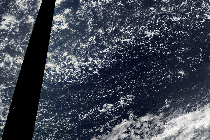

In [24]:
Transform(lambda o: Image.Image.resize_max(o, max_w=210))(im)

In [27]:
class RescaleTfm(Transform):
    def __init__(self, max_w=210, resample=Image.BILINEAR): 
        self.max_w, self.resample = max_w, resample
        
    def encodes(self, o:PILImage): return o.resize_max(max_w=self.max_w, resample=self.resample)
    def encodes(self, o:PILMask): return o.resize_max(max_w=self.max_w, resample=Image.NEAREST)


In [31]:
rescale = RescaleTfm(max_w=210, resample=0)

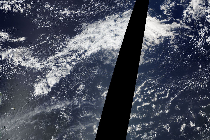

In [32]:
rescale(PILImage.create(items[8]))

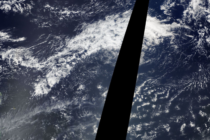

In [33]:
RescaleTfm(max_w=210, resample=Image.BILINEAR)(PILImage.create(items[8]))

The difference between `resample=0` and `resample=Image.BILINEAR` can be seen above.  For now, `resample=0` will be used.  And the width is reduced to 210 px.  This `Transform` will be used   when creating the `DataBunch` below.

In [69]:
SZ = 210

In [70]:
rescale = RescaleTfm(max_w=SZ, resample=0)

### DataSource

A `Transform` is created that will transform an image file path to its *flower* cloud mask, a `np.array`.  The downloaded train set is split randomly into a train and valid set, using `RandomSplitter`.

In [38]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    
    Copied from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [39]:
CAT = 'flower'

In [40]:
class RLE_Decode(Transform):
    def __init__(self, annots, img_shape): self.annots, self.img_shape = annots, img_shape
        
    def encodes(self, o):
        df = self.annots[self.annots.Image == o.stem].fillna('')
        pxenc = df[df.Label == CAT].EncodedPixels.values[0]
        return rle_decode(pxenc, self.img_shape)

In [42]:
split_idx = RandomSplitter()(items)
tfms = [[PILImage.create, ], 
        [RLE_Decode(annots, IMG_SHAPE), PILMask.create]]
dsrc = DataSource(items, tfms=tfms, splits=split_idx)

### DataBunch
Convert the `DataSource` into a `DataBunch`, which is the object that can load mini-batches for training.  In the process, additional data transformations are specified.  

In [80]:
item_img_tfms = [RescaleTfm(max_w=SZ, resample=0), ToTensor,]

In [72]:
batch_tfms = [Cuda(), IntToFloatTensor(),]

In [73]:
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=4)

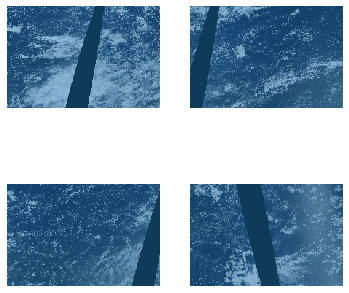

In [74]:
dbch.show_batch()

### Image normalization
Find the mean and standard deviation for each colour channel, from a batch of images.  These stats are used to form a `Normalize` transform.  The `DataBunch` is re-created with the addition of this `Transform`.

In [126]:
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=64)

In [127]:
xb, yb = dbch.one_batch()

In [135]:
xb.shape, yb.shape, IMG_SZ

(torch.Size([64, 3, 1400, 2100]), torch.Size([64, 1400, 2100]), (1400, 2100))

In [128]:
cloud_stats = [xb.mean(dim=[0, 2, 3]), xb.std(dim=[0, 2, 3])]
cloud_stats

[tensor([0.2665, 0.2844, 0.3323]), tensor([0.2578, 0.2532, 0.2383])]

Mean: [0.2556, 0.2727, 0.3182]  
Standard deviation:  [0.2475, 0.2429, 0.2294]

In [59]:
cloud_stats = [tensor([0.2556, 0.2727, 0.3182]), tensor([0.2475, 0.2429, 0.2294])]

In [60]:
cloud_stats = broadcast_vec(1, 4, *cloud_stats)

In [62]:
cloud_stats[0].shape, cloud_stats[1].shape

(torch.Size([1, 3, 1, 1]), torch.Size([1, 3, 1, 1]))

In [75]:
batch_tfms += [Normalize(*cloud_stats)]
dbch = dsrc.databunch(bs=4, after_item=item_img_tfms, after_batch=batch_tfms)

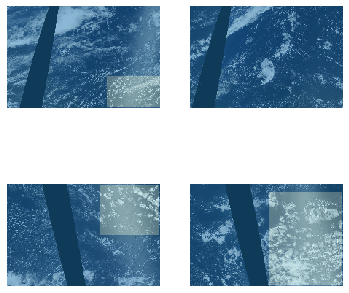

In [76]:
dbch.show_batch()

In [77]:
xb, yb = dbch.one_batch()

In [78]:
xb.mean(dim=[0, 2, 3]), xb.std(dim=[0, 2, 3])

(tensor([-0.0902, -0.0886, -0.0752]), tensor([0.8337, 0.8404, 0.8519]))

In [79]:
xb.shape, yb.shape

(torch.Size([4, 3, 140, 210]), torch.Size([4, 140, 210]))

Now, the `DataBunch` loads mini-batches of size 4, where the images and masks have a width of 210 px, with the original aspect ratio.

# End